<a href="https://colab.research.google.com/github/drSever/drSever_data_science/blob/main/Learning_projects_dl/project_6/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Работа с моделью

## Импортируем необходимые библиотеки

In [1]:
import os
import random

from google.colab import drive

import pandas as pd
import numpy as np

import colorsys
import cv2
import albumentations as A
from tqdm.auto import tqdm

import torch

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import torchvision
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

## Подключаем Google Drive и распаковываем данные

Подключим Google Drive:

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Распакуем данные в локальную папку `data`:

In [3]:
!unzip -q /content/gdrive/MyDrive/Colab_Notebooks/Learning_projects/Segmentation_2_Kaggle/sartorius-cell-instance-segmentation.zip

In [4]:
old_name = r"/content/sartorius-cell-instance-segmentation"
new_name = r"/content/data"
os.rename(old_name, new_name)

## Пишем необходимые функции и проверяем их работу

In [5]:
def random_colors(N, bright=True):
    """
    Генерирует случайные цвета.
    Чтобы получить визуально различимые цвета, генерирует их в пространстве HSV, а затем
    преобразовывает в RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    # Преобразование цвета из координат HSV в координаты RGB
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    # перемешивает последовательность (список) случайным образом
    random.shuffle(colors)
    return colors

In [6]:
def decode_rle_mask(rle_mask, shape=(520, 704)):

    """
    Декодирование закодированной строки маски сегментации в двумерный массив

    Параметры
    ----------
    rle_mask (str): Строка маски сегментации в кодировке длины пробега
    shape (tuple): Высота и ширина маски

    Возвращает
    -------
    mask [numpy.ndarray of shape (height, width)]: Декодированная маска двухмерной сегментации
    """

    rle_mask = rle_mask.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (rle_mask[0:][::2], rle_mask[1:][::2])]
    starts -= 1
    ends = starts + lengths

    mask = np.zeros((shape[0] * shape[1]), dtype=np.uint8)
    for start, end in zip(starts, ends):
        mask[start:end] = 1

    mask = mask.reshape(shape[0], shape[1])
    mask = np.uint8(mask) # для того, чтобы не было проблем с аугментацией
    return mask


def encode_rle_mask(mask, shape=(520, 704)):
    pixels = mask.flatten() # массив в вектор
    pixels = np.concatenate([[0], pixels, [0]])
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 1
    rle[1::2] -= rle[::2]
    return rle.tolist()

In [7]:
def get_bboxes_from_mask(masks):
    coco_boxes = []
    for mask in masks:
        pos = np.nonzero(mask) # получаем массив с координатами ненулевых значений
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        coco_boxes.append([xmin, ymin, xmax, ymax])
    coco_boxes = np.asarray(coco_boxes) # преобразуем в array для даталоадера
    return coco_boxes

In [8]:
def get_targets_mask(df, img_id):
    targets = df[df['id'] == img_id]['cell_type'].apply(lambda x: cls_map[x]).values
    rles = df[df['id'] == img_id]['annotation'].values
    return targets, rles

In [9]:
train_df = pd.read_csv('data/train.csv')

In [10]:
# это надо для преобразования cell_type в цифры - LabelEncoding
cls_map = {value:idx for idx, value in enumerate(train_df['cell_type'].unique())}
cls_map_reversed = {cls_map[key]: key for key in cls_map.keys()}

In [11]:
img_id = train_df.iloc[0]['id']
img = cv2.imread(f'data/train/{img_id}.png')

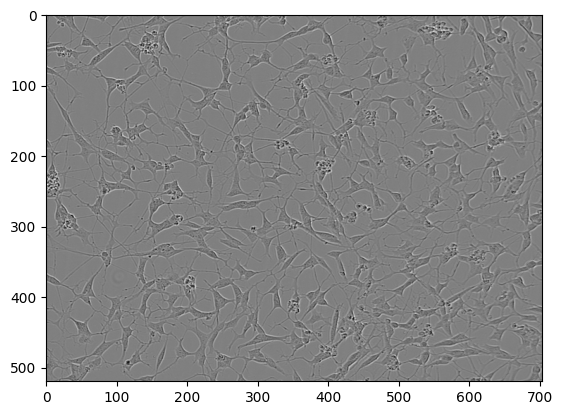

In [12]:
plt.imshow(img);

In [13]:
labels, rles = get_targets_mask(train_df, img_id)

In [14]:
len(rles)

395

In [15]:
mask = decode_rle_mask(rles[0]) # первая (по индексу) маска

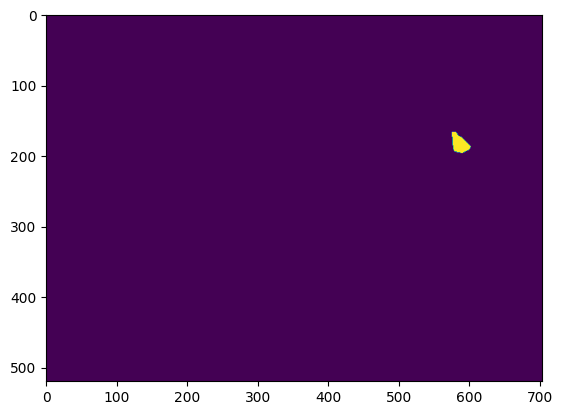

In [16]:
plt.imshow(mask);

In [17]:
mask.flatten()[1::2].shape

(183040,)

In [18]:
mask.flatten().shape

(366080,)

In [19]:
mask = decode_rle_mask(str(encode_rle_mask(mask)).replace('[', '').replace(']', '').replace(',', ''))

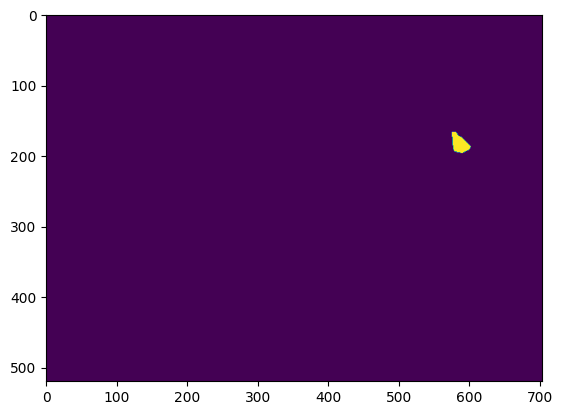

In [20]:
plt.imshow(mask);

In [21]:
masks = []
for mask in train_df.loc[train_df['id'] == img_id, 'annotation'].values:
    decoded_mask = decode_rle_mask(rle_mask=mask, shape=img.shape)
    masks.append(decoded_mask)

In [22]:
bboxes = get_bboxes_from_mask(masks)

In [23]:
def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

In [24]:
def plot_image_annotations(image, masks, bboxes, labels, aug=None):
    image = image.copy()

    colors = {unique_lbl:random_colors(1, True)[0] for unique_lbl in np.unique(labels)}

    if aug is not None:
        augmented = aug(image=image, masks=masks, bboxes=bboxes,
                        labels=labels)
        image = augmented['image']
        masks = augmented['masks']
        bboxes = augmented['bboxes']

    bboxes = np.stack(bboxes).astype(int)

    for idx, box in enumerate(bboxes):
        color = tuple([int(value*255) for value in colors[labels[idx]]])
        image = cv2.rectangle(image, (box[2], box[3]), (box[0], box[1]), color=color, thickness=2) # рамка

    for idx, mask in enumerate(masks):
        color = colors[labels[idx]]
        image = apply_mask(image, mask, color)

    plt.figure(figsize=(15, 15))
    plt.imshow(image)
    plt.show()

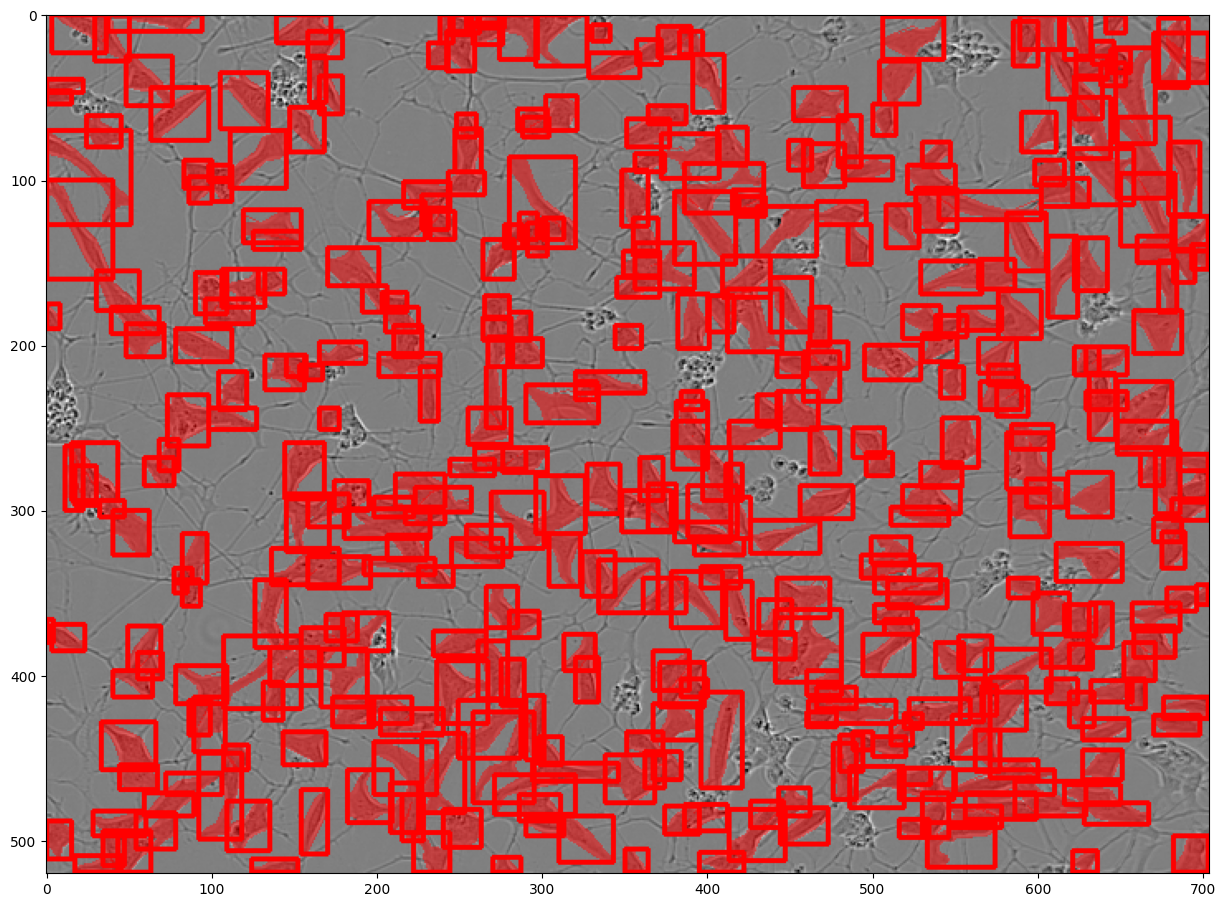

In [25]:
plot_image_annotations(image=img, masks=masks, bboxes=bboxes, labels=labels)

In [26]:
train_augmentations = A.Compose([
    A.RandomResizedCrop(640, 640, scale=(0.8, 1.0), ratio=(0.9, 1.3)),
    A.HorizontalFlip(),
    A.RandomRotate90()
], bbox_params={"format": "pascal_voc", "min_area": 0, "min_visibility": 0, 'label_fields': ['labels']})

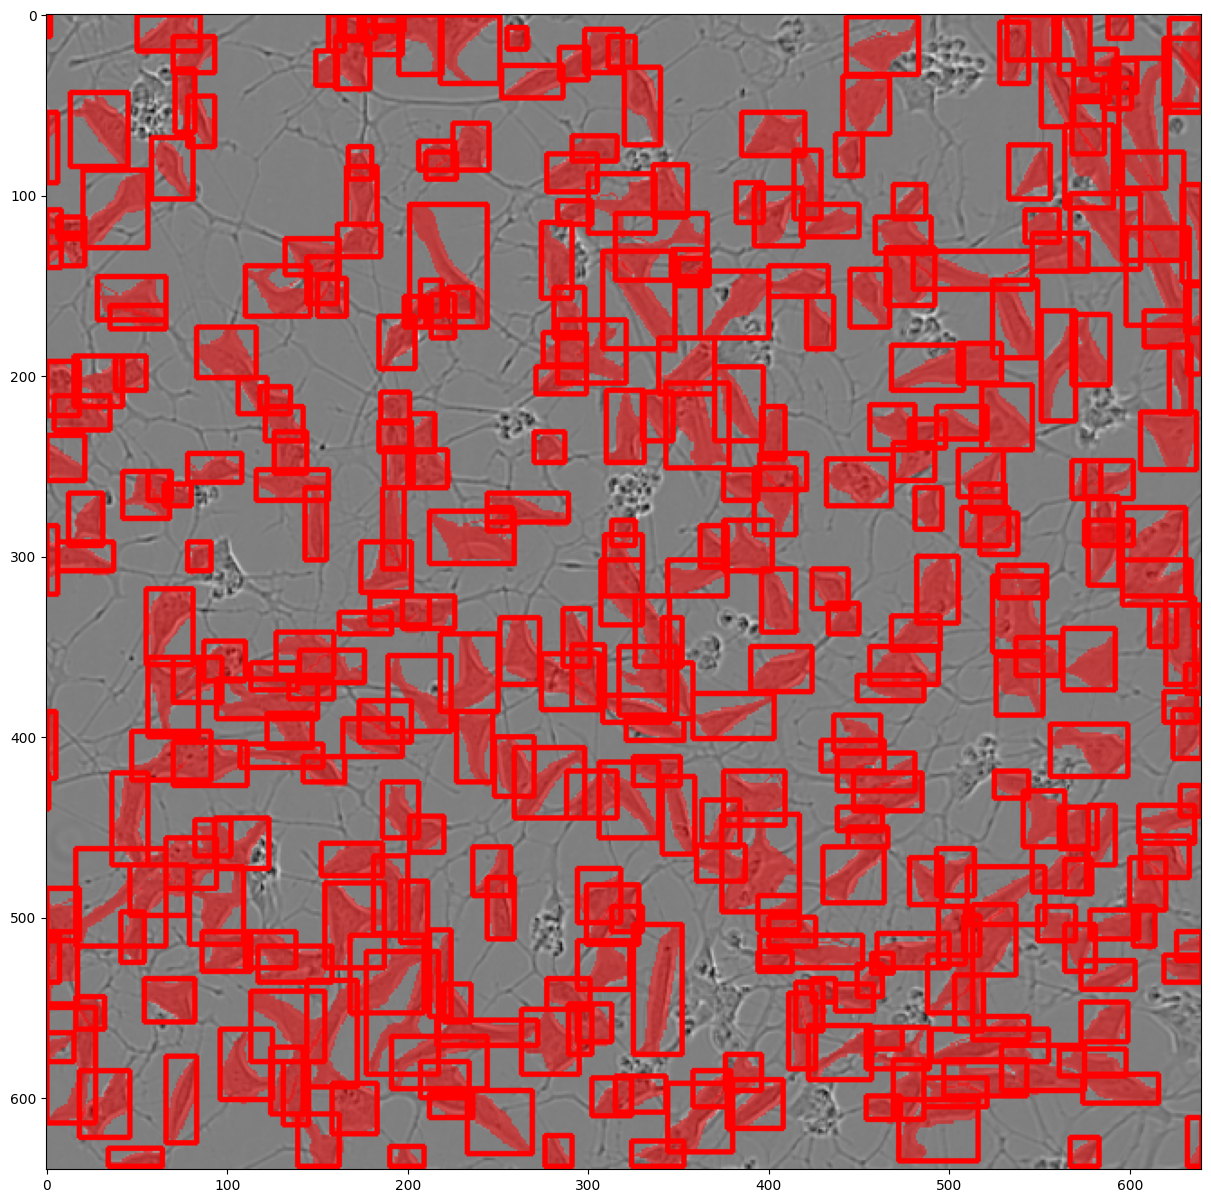

In [27]:
plot_image_annotations(image=img, masks=masks, bboxes=bboxes, labels=labels, aug=train_augmentations)

## Работа с моделью

Напишем Даталоадер для обучения

In [28]:
class CellSegData(torch.utils.data.Dataset):
    def __init__(self, root, df, split='train', aug=None, cls_map=None):
        self.augmentations = aug
        self.cls_map = cls_map

        train, test = train_test_split(df['id'].unique(), train_size=0.9)
        if split == 'train':
            self.dataset = train
        else:
            self.dataset = test

        self.dict_df = {img_id: df[df['id'] == img_id] for img_id in tqdm(self.dataset)}
        self.root = root

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img_id = self.dataset[index]
        image = cv2.imread(os.path.join(self.root, img_id + '.png'))

        info = self.dict_df[img_id]
        n_objects = len(info['annotation'])

        labels = info['cell_type'].apply(lambda x: self.cls_map[x]).values
        rles = info['annotation'].values

        masks = []
        for mask in rles:
            decoded_mask = decode_rle_mask(rle_mask=mask, shape=image.shape)
            masks.append(decoded_mask)

        bboxes = get_bboxes_from_mask(masks)

        if self.augmentations is not None:
            augmented = self.augmentations(image=image, masks=masks, bboxes=bboxes,
                                           labels=labels)
            image = augmented['image']
            masks = augmented['masks']
            bboxes = augmented['bboxes']
            bboxes = np.stack(bboxes).astype(int)

        masks = np.asarray(masks)

        bboxes = torch.as_tensor(bboxes, dtype=torch.int64)

        is_bad_labels = False
        degenerate_boxes = bboxes[:, 2:] <= bboxes[:, :2]
        if degenerate_boxes.any():
            is_bad_labels = True
            # print the first degenerate box
            bb_idxs = torch.where(degenerate_boxes.any(dim=1))[0].numpy()

        labels = torch.as_tensor([1 for i in range(len(bboxes))], dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        if is_bad_labels:
            bboxes = bboxes[[i for i in range(len(bboxes)) if i not in bb_idxs]]
            labels = labels[[i for i in range(len(bboxes)) if i not in bb_idxs]]
            masks = masks[[i for i in range(len(bboxes)) if i not in bb_idxs]]

        image_id = torch.tensor([index])
        area = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        iscrowd = torch.zeros((n_objects,), dtype=torch.int64)

        # This is the required target for the Mask R-CNN
        target = {
            'boxes': bboxes,
            'labels': labels,
            'masks': masks,
            'image_id': image_id,
            'area': area,
            'iscrowd': iscrowd
        }

        image = image.transpose((2, 0, 1))
        return torch.Tensor(image), target

Функция для визуализации работы модели на валидации

In [29]:
def analyze_train_sample(model, ds_train, sample_index):
    img, targets = ds_train[sample_index]
    plt.imshow(img.numpy().astype(np.uint8).transpose((1, 2, 0)))
    plt.title("Image")
    plt.show()

    masks = np.zeros((640, 640))
    for mask in targets['masks']:
        masks = np.logical_or(masks, mask)
    plt.imshow(img.numpy().transpose((1, 2, 0)))
    plt.imshow(masks, alpha=0.3)
    plt.title("Ground truth")
    plt.show()

    model.eval()
    with torch.no_grad():
        preds = model([img.cuda()])[0]

    plt.imshow(img.cpu().numpy().transpose((1, 2, 0)))
    all_preds_masks = np.zeros((640, 640))
    for mask in preds['masks'].cpu().detach().numpy():
        all_preds_masks = np.logical_or(all_preds_masks, mask[0] > 0.5)
    plt.imshow(all_preds_masks, alpha=0.4)
    plt.title("Predictions")
    plt.show()

Клонируем дополнительно репозиторий с нужными скриптами

In [30]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 474859, done.
remote: Counting objects: 100% (55317/55317), done.
remote: Compressing objects: 100% (2508/2508), done.
remote: Total 474859 (delta 52847), reused 55131 (delta 52726), pack-reused 419542
Receiving objects: 100% (474859/474859), 931.68 MiB | 29.14 MiB/s, done.
Resolving deltas: 100% (441950/441950), done.
Note: switching to 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 2f40a483d7 [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


Теперь можно выполнить импорт `utils`:

In [31]:
import utils

Обучаем модель

In [ ]:
# создаем датафрейм из train.csv
train_df = pd.read_csv('data/train.csv')

# карта классов
cls_map = {value: idx for idx, value in enumerate(train_df['cell_type'].unique())}

# задаем аугментации
train_augmentations = A.Compose([
    A.Resize(640, 640),
    # A.RandomResizedCrop(640, 640, scale=(0.8, 1.0), ratio=(0.9, 1.3)),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.RandomRotate90()
], bbox_params={"format": "pascal_voc", "min_area": 0, "min_visibility": 0, 'label_fields': ['labels']})

# задаем количество эпох обучения
num_epochs = 50

# задаем устройство для обучения модели
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# создаем тренировочный и валидационный датасеты и производим необходимые аугментации
dataset = CellSegData('data/train', train_df, 'train', train_augmentations, cls_map)
dataset_test = CellSegData('data/train', train_df, 'test', train_augmentations, cls_map)

# создаем тренировочный и валидационный даталоадеры
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=2, prefetch_factor=2, collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4, collate_fn=utils.collate_fn)

# задаем количество классов (+ background)
NUM_CLASSES = 4

# загружаем необученную модель
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False,
                                                            box_detections_per_img=600) # максимальное количество детекций на изображении (для всех классов)

# получаем количество входных признаков для box_predictor
in_features = model.roi_heads.box_predictor.cls_score.in_features
# заменяем box_predictor
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)

# получаем количество входных признаков для mask_predictor
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
# заменяем mask_predictor
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, NUM_CLASSES)
# weights = torch.load('weights/checkpoint.pth')
# move model to the right device
# model.state_dict(weights['model'])
model.to(device)

# задаем optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=0.0001)
# optimizer.load_state_dict(weights['optimizer'])
# задаем learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

# сюда скидываем веса обученной модели
output_dir = '/content/gdrive/MyDrive/Colab_Notebooks/Learning_projects/Segmentation_2_Kaggle/weights'
os.makedirs(output_dir, exist_ok=True)

# обучение
for epoch in tqdm(range(num_epochs)):
    # обучение в течение одной эпохи, печать каждые 10 итераций
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value:.6f}"))
    header = f"Epoch: [{epoch}]"

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    for images, targets in metric_logger.log_every(data_loader, 10, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    analyze_train_sample(model, dataset, 20)
    # evaluate on the test dataset
    # evaluate(model, data_loader_test, device=device)
    if output_dir:
        checkpoint = {
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "epoch": epoch,
        }
        utils.save_on_master(checkpoint, os.path.join(output_dir, f"model_{epoch}.pth"))
        utils.save_on_master(checkpoint, os.path.join(output_dir, "checkpoint.pth"))

**Промежуточные выводы:**
- за основу взят представленный ноутбук преподавателя SkillFactory
- данный ноутбук был несколько переработан
- проведено обучение модели на 50 эпохах с использованием платформы Google Colab Pro
- веса обученной модели сохранены на Google Disk

## Инференс

Инференс будет производится после обучения модели. Для экономии ресурсов и денег в качестве `device` будет использоваться `cpu`. Повторно будет загружена модель, отредактирована ее архитектура и будут загружены наши веса. Инференс будет произведен на изображениях, которые находятся в папке `test`.

In [32]:
# путь к сохраненным весам нашей модели (получены выше)
path = "/content/gdrive/MyDrive/Colab_Notebooks/Learning_projects/Segmentation_2_Kaggle/weights/model_50.pth"

# инференс будем проводить на cpu
device = torch.device('cpu')

# загрузим пустой sample_submission
test_df = pd.read_csv('data/sample_submission.csv')

Готовим модель:

In [ ]:
# количество классов (+ background)
NUM_CLASSES = 4

# загрузим снова модель
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=None,
                                                            box_detections_per_img=600)

# получаем количество входных признаков для box_predictor
in_features = model.roi_heads.box_predictor.cls_score.in_features
# заменяем box_predictor
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)

# получаем количество входных признаков для mask_predictor
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
# заменяем mask_predictor
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, NUM_CLASSES)

# загружаем наши веса (получены и сохранены выше)
model.load_state_dict(torch.load(path, map_location=device)['model'])

# переносим модель в cpu и переводим ее в режим eval
model = model.to(device)
model.eval()

Зададим класс тестового датасета (смысла большого в этом, наверное, нет, но мне интересно самому его написать):

In [34]:
class CellSegData_test(torch.utils.data.Dataset):
    def __init__(self, root, df):
        self.root = root
        self.dataset = df['id'].unique()

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img_id = self.dataset[index]
        image = cv2.imread(os.path.join(self.root, img_id + '.png'))


        image = image.transpose((2, 0, 1))

        return torch.Tensor(image)

Напишем функцию для визуализауии предсказаний модели:

In [53]:
def analyze_test_sample(model, ds_test, sample_index):
    """
    Функция принимет на вход модель, тестовый датасет и индекс.
    Используя модель, предсказыввет маски и визуализирует
    результат предсказания.
    """
    # задаем фигуру (1 строка, 2 колонки)
    fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

    # из датасета получаем изображение и выводим его
    img = ds_test[sample_index]
    axs[0].imshow(img.numpy().astype(np.uint8).transpose((1, 2, 0)))
    axs[0].title.set_text("Image")

    # делаем предсказание, получаем маски и визуализируем результат
    with torch.no_grad():
        preds = model([img.to(device)])[0]

    axs[1].imshow(img.to(device).numpy().transpose((1, 2, 0)))
    all_preds_masks = np.zeros((520,704))
    for mask in preds['masks'].to(device).detach().numpy():
        all_preds_masks = np.logical_or(all_preds_masks, mask[0] > 0.5)
    axs[1].imshow(all_preds_masks, alpha=0.4)
    axs[1].title.set_text("Predictions")

    plt.show();

Создадим тестовый датасет:

In [36]:
dataset_test = CellSegData_test('data/test', test_df)

Визуализируем предсказания нашей обученной модели:

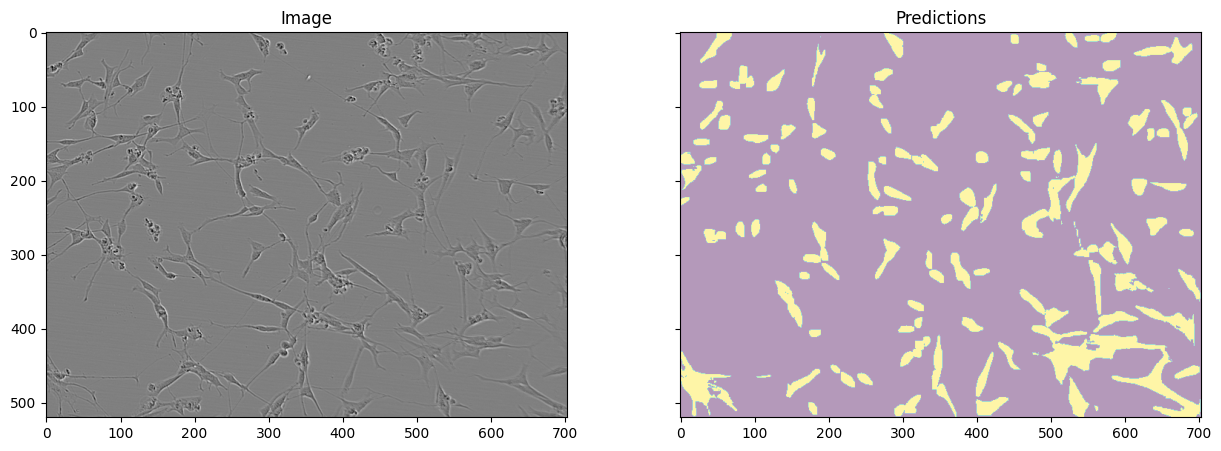

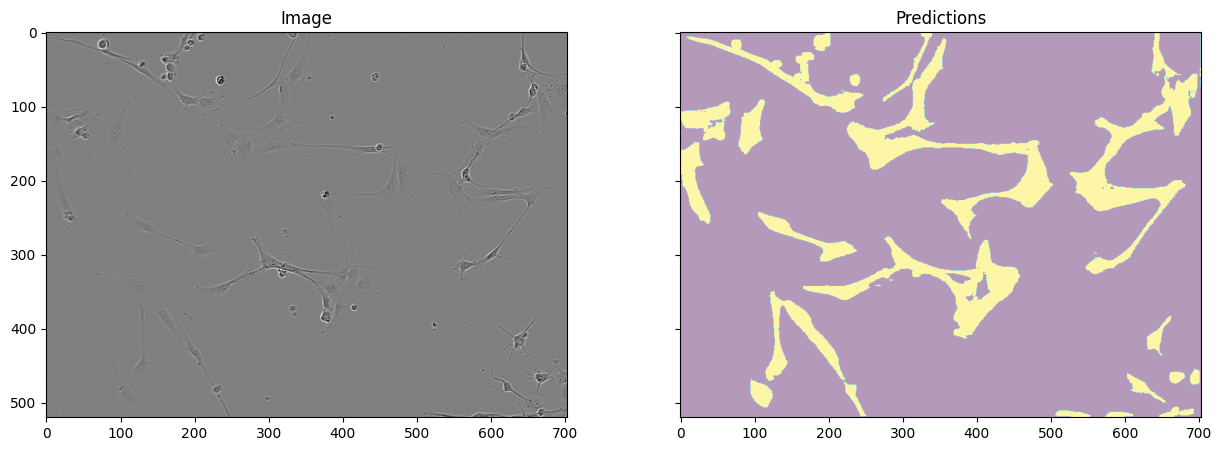

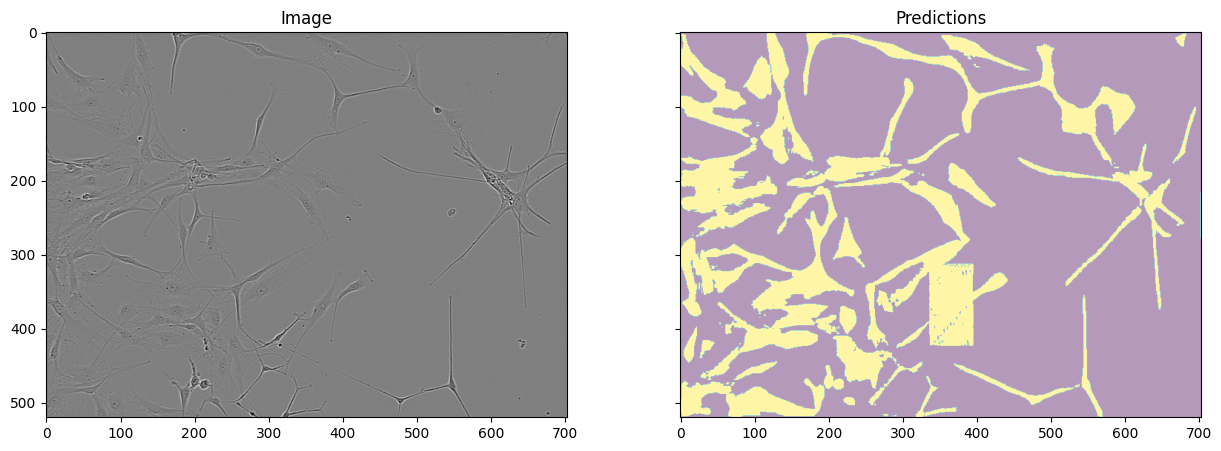

In [60]:
for i in range(len(dataset_test)):
    analyze_test_sample(model, dataset_test, i)

**Вывод:** далеко не идеально, но лучше, чем я ожидал. Для Baseline пока достаточно.

In [69]:
def make_submission(model, dataset, df):
    """
    Функция принимает на вход модель, тестовый датасет, тестовый датафрейм.
    Выполняет предсказание модели, сохраняет submision и выводит его.
    """
    rles = []
    for i in range(len(dataset)):
        with torch.no_grad():
            preds = model([dataset_test[i].to(device)])
        # переводим предсказания в формат исходного датасета
        rle = str(encode_rle_mask(preds[0]['masks'][0])).replace('[', '').replace(']', '').replace(',', '')
        rles.append(rle)

    test_df['predicted'] = rles

    test_df.to_csv("submission.csv", index=False)

    display(test_df)

In [70]:
make_submission(model, dataset_test, test_df)

,id,predicted
0,7ae19de7bc2a,138593 1 138595 1 138597 1 138599 1 138601 1 1...
1,d48ec7815252,48535 1 48537 1 48539 1 48541 1 48543 1 48545 ...
2,d8bfd1dafdc4,328974 1 328976 1 328978 1 328980 1 328982 1 3...


In [71]:
# сохраним зависимости
!pip freeze > requirements.txt